In [1]:
import numpy as np
from scipy.stats import multivariate_normal as norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Loading the training and test data

## Train data

In [2]:
train5 = np.loadtxt("data/train5.txt")/255 # /255 for normalization
train6 = np.loadtxt("data/train6.txt")/255
train8 = np.loadtxt("data/train8.txt")/255

In [3]:
# Define targets 
train5_target = 5*np.ones(len(train5))
train6_target = 6*np.ones(len(train6))
train8_target = 8*np.ones(len(train8))

In [4]:
# Combine data
train_data = np.concatenate([train5, train6, train8])
train_targets = np.concatenate([train5_target, train6_target, train8_target])

## Test data

In [5]:
test5 = np.loadtxt("data/test5.txt")/255
test6 = np.loadtxt("data/test6.txt")/255
test8 = np.loadtxt("data/test8.txt")/255

# Define targets 
test5_target = 5*np.ones(len(test5))
test6_target = 6*np.ones(len(test6))
test8_target = 8*np.ones(len(test8))

# Combine
test_data = np.concatenate([test5, test6, test8])
test_targets = np.concatenate([test5_target, test6_target, test8_target])

# Class names
classes = np.array([5,6,8])

# Part 1: Reduce dimension to 2
Here, we wish to reduce the data dimensionality from 784 to 2 using either PCA or LDA.
For this you can use scikit-learn.

## PCA

The PCA class in scikit-learn fits a covariance matrix and compute eigenvectors for you. 
PCA doesn't assume any knowledge about the classes, so you have to use the concatenated training set.

In [6]:
# Fit a scikit learn PCA instance to training data
PCA_model = PCA(n_components=2)
PCA_model.fit(train_data)

PCA(n_components=2)

Now that the PCA model is fit to the training data, we can find a low dimesional representation of each class.

In [7]:
# Transform train data from each class using fitted PCA instance
PCA_train = PCA_model.transform(train_data)

## LDA
We can also use Linear Disicriminant Analysis to reduce the dimensionality of the data.
The LDA class in scikit-learn fits a covariance matrix and compute eigenvectors for you. LDA assume that you know about the classes, so you have to use the concatenated training set and targets/classes

In [8]:
# Fit a scikit learn LDA instance to training data
LDA_model = LDA(n_components=2)
LDA_model.fit(train_data, train_targets)

LinearDiscriminantAnalysis(n_components=2)

In [9]:
# Transform train data from each class using fitted LDA instance
LDA_train = LDA_model.transform(train_data)

Let's try to plot the dimensionality reduced data and compare PCA to LDA. What do we see?

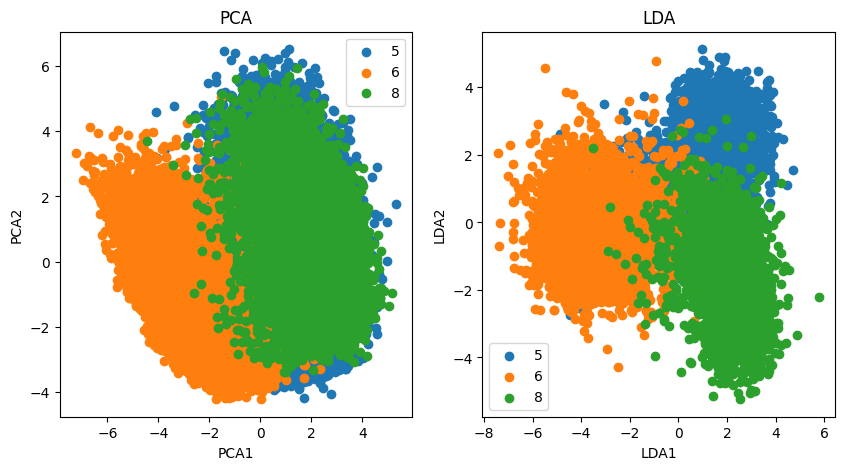

In [10]:
#Scatter plot of the dimensional-reduced data 

plt.subplots(1,2, figsize=(10,5))
# PCA plot
plt.subplot(1,2,1)
plt.scatter(PCA_train[train_targets==5,0], PCA_train[train_targets==5,1], label='5')
plt.scatter(PCA_train[train_targets==6,0], PCA_train[train_targets==6,1], label='6')
plt.scatter(PCA_train[train_targets==8,0], PCA_train[train_targets==8,1], label='8')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA')
plt.legend()



# LDA plot
plt.subplot(1,2,2)
plt.scatter(LDA_train[train_targets==5,0], LDA_train[train_targets==5,1], label='5')
plt.scatter(LDA_train[train_targets==6,0], LDA_train[train_targets==6,1], label='6')
plt.scatter(LDA_train[train_targets==8,0], LDA_train[train_targets==8,1], label='8')
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('LDA')
plt.legend()

plt.show()

In the above plot we see that LDA is seemingly better at seperating the tree classes,while the classes 5 and 8 are highly overlapped when using PCA.

# Part 2: Perform 3-class classification based on the generated 2-dimensional data. 
We need to find a model to classify the test data as either 5, 6, or 8.
Here, we could use a Gaussian model for each class, and estimate the mean and covariance from the dimensionality reduced data.

## Estimate Gaussians using 2-dimensional data obtained from PCA

In [12]:
def likelihood(data, mean, cov):
    likelihood_value = norm(mean=mean, cov=cov).pdf(data)
    return likelihood_value

In [20]:
#Estimate parameters for a bivariante Gaussian distribution.
PCA_means = np.zeros((3,2))
PCA_covs = np.zeros((3,2,2))

for i in range(3):
    # Estimate mean and covariance for each class using PCA-transformed train data
    PCA_means[i] = np.mean(PCA_train[train_targets==classes[i]], axis=0)
    PCA_covs[i] = np.cov(PCA_train[train_targets==classes[i]].T)

## Estimate Gaussians using 2-dimensional data obtained from LDA

In [21]:
#Estimate parameters for a bivariante Gaussian distribution.
LDA_means = np.zeros((3,2))
LDA_covs = np.zeros((3,2,2))

for i in range(3):
    LDA_means[i] = np.mean(LDA_train[train_targets==classes[i]], axis=0)
    LDA_covs[i] = np.cov(LDA_train[train_targets==classes[i]].T)

## Classifying test data
To classify the test data, we first transform it to 2-dimensions as well.

In [22]:
# Transform test data using fitted PCA/LDA instance
PCA_test = PCA_model.transform(test_data)
LDA_test = LDA_model.transform(test_data)

Now we compute priors, likelihoods and posteriors

In [25]:
# PCA
PCA_priors = np.zeros(3)
PCA_likelihoods = np.zeros((len(test_data),3))
PCA_posteriors = np.zeros((len(test_data),3))

#LDA
LDA_priors = np.zeros(3)
LDA_likelihoods = np.zeros((len(test_data),3))
LDA_posteriors = np.zeros((len(test_data),3))

for i in range(3):
    # Compute priors
    PCA_priors[i] = np.sum(train_targets==classes[i])/len(train_targets)
    # Compute Likelihoods
    PCA_likelihoods[:,i] = likelihood(PCA_model.transform(test_data), PCA_means[i], PCA_covs[i])
    # Compute posteriors
    PCA_posteriors[:,i] = PCA_priors[i]*PCA_likelihoods[:,i]
    
    # Compute priors
    LDA_priors[i] = np.sum(train_targets==classes[i])/len(train_targets)
    # Compute Likelihoods
    LDA_likelihoods[:,i] = likelihood(LDA_model.transform(test_data), LDA_means[i], LDA_covs[i])
    # Compute posteriors
    LDA_posteriors[:,i] = LDA_priors[i]*LDA_likelihoods[:,i]


We can now compute the classification accuracy for both PCA and LDA

In [31]:
#Compute predictions
PCA_predictions = classes[np.argmax(PCA_posteriors, axis=1)]
LDA_predictions = classes[np.argmax(LDA_posteriors, axis=1)]

#Compute accuracy
accuracy_PCA = np.sum(PCA_predictions==test_targets)/len(test_targets)
accuracy_LDA = np.sum(LDA_predictions==test_targets)/len(test_targets)
print(f'PCA accuracy: {accuracy_PCA}')
print(f'LDA accuracy: {accuracy_LDA}')

PCA accuracy: 0.7103399433427762
LDA accuracy: 0.9447592067988668


#### What does the results show?
The result shows that the LDA is superior for this classification task. This can also be seen in the scatterplot, where the PCA has a lot of overlap between the numbes 5 and 8.